# SEG-Y in Python

I have tested two ways to work with SEG-Y data:

* [ObsPy](https://github.com/obspy/obspy/wiki): big, very complete and very complex;
* [Segpy](https://github.com/rob-smallshire/segpy/), a fork of an old library called [SegyPy](http://segymat.sourceforge.net/segypy/) (note the additional *y*); smaller & simpler.

# Loading data with ObsPy

Let's load a SEG-Y first. I will use 2D lines taken from the [USGS Alaska land dataset](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx). Acknowledgements and kudos to [Evan Bianco](https://twitter.com/evanbianco) who showed me how to use ObsPy.

In [34]:
from obspy.segy.segy import readSEGY

file1='16_81_PT1_PR.SGY'
segy1=readSEGY(file1,unpack_headers=True)

We can look at the EBCDIC header (i.e., the textual header that is supposed to contain all sort of important information) and the binary header:

In [35]:
segy1.textual_file_header

'C01 CLIENT/JOB ID    1 8 1 4 2 6 8 3                                            C02 LINE    16X                                                                 C03 REEL NO 810604181418   DAY-START OF REEL  04       YEAR 1981                C04 INSTRUMENT: MFG TI          MODEL ASC                                       C05 DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  C06 SAMPLE RATE   0000004000 US  SAMPLES/TRACE  1501BITS/IN 1600 BYTES/SAMPLE 4 C07 RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 C08 SAMPLE CODE: FLOATING PT 4 BYTE                                             C09 GAIN TYPE:   FLOATING PT                                                    C10                                                                             C11                                                                             C12                                                                             C13                                    

To get some information about the data we interrogate the binary header in this way:

In [38]:
print 'number of traces: %d, samples: %d, sample rate: %d' % (len(segy1.traces), segy1.binary_file_header.number_of_samples_per_data_trace, segy1.binary_file_header.sample_interval_in_microseconds)
print 'trace length (ms): %.2f' % (segy1.binary_file_header.sample_interval_in_microseconds/1e3 * segy1.binary_file_header.number_of_samples_per_data_trace)
print 'line number: %d' % segy1.binary_file_header.line_number

number of traces: 1912, samples: 1501, sample rate: 4000
trace length (ms): 6004.00
line number: 16


To access the individual trace headers use this syntax:

    print segy1.traces[0].header
    
This will print out information about the first trace (`[0]`); if you want information on the 56th trace, remember that Python's list are 0-based and ask for:

    print segy1.traces[55].header
        
To actually read the data the procedure seems to be a bit clunky and needs a `for` loop (which may be very slow for large dataset). I haven't found another way to do it yet, and I haven't further investigated this issue since I am now using Segpy to do stuff with seismic.

Anyway that's the way to load the actual data into a Numpy array:

In [39]:
import numpy as np

data = np.zeros((segy1.binary_file_header.number_of_samples_per_data_trace, len(segy1.traces)))
for i, trace in enumerate(segy1.traces):
  data[:,i] = trace.data

print 'seismic is (number of samples, nr of traces):', np.shape(data)

clip=abs(np.percentile(data, 0.999))

print 'clip value for data display:', clip

seismic is (number of samples, nr of traces): (1501, 1912)
clip value for data display: 1667.94457527


I have defined a function that takes the segy structure created by ObsPy and gives me back all I need, i.e.:

* `output`, NumPy array containing the actual data
* `twt`, the z-axis vector (standard acronym for "two-way-time", but you can call it `meters` if what you're loading is a PSDM volume)
* `nsamples`, number of samples
* `sr`, sample rate
* `clip_val`, recommended clip value to display the data

In [40]:
def copy_segy(inputsegy,lag):
    import numpy as np
    ntraces=len(inputsegy.traces)
    nsamples=inputsegy.binary_file_header.number_of_samples_per_data_trace
    sr=inputsegy.binary_file_header.sample_interval_in_microseconds
    twt=np.arange(lag,lag+nsamples*sr/1000.,sr/1000.)
    output = np.zeros((nsamples, ntraces))  # shape=row,column --> twt i.e. nsamples, ntraces
    for i, trace in enumerate(inputsegy.traces):
        output[:,i] = trace.data
    clip_val = abs(np.percentile(output, 0.999))   # default clip value
    print 'number of traces/samples/sample rate :', ntraces, nsamples, sr
    print 'first / last sample twt              :', twt[0], twt[-1]
    print 'value to clip data display           :', clip_val
    return output, ntraces, nsamples, sr, twt, clip_val

Let's try it:

In [41]:
(line1,nt1,ns1,sr1,twt1,clip1)=copy_segy(segy1,0)

number of traces/samples/sample rate : 1912 1501 4000
first / last sample twt              : 0.0 6000.0
value to clip data display           : 1667.94457527


So we now that we have 1912 traces, each traces is made of 1501 samples, which multiplied by the sample rate (4 microseconds) gives me 6 seconds of data. So my numpy array `line1` will have this shape - remember that a numpy array is (_rows_,_columns_):

In [42]:
line1.shape

(1501, 1912)

# Show the seismic

I have also defined a simple function to do a quick plot of the data:

In [43]:
def plot_seismic(inputseis,twt,name,colr=None,clip_val=None):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    ntraces=np.shape(inputseis)[1]
    if clip_val is None:
        clip_val=abs(np.percentile(inputseis, 0.999))   # default clip value
    if colr is None:
        colr=cm.seismic # altre opzioni possibili: cm.gray,cm.coolwarm, cm.RdGy
    f, ax = plt.subplots(figsize=(16,6),facecolor='w')
    im=ax.imshow(inputseis,interpolation='bilinear',aspect='auto',cmap=colr,extent=(0,ntraces,twt[-1],twt[0]),vmin=-clip_val,vmax=clip_val)
    plt.xlabel('Trace no.'), plt.ylabel('Two-way time [ms]')
    plt.title(name), plt.grid(), plt.colorbar(im)

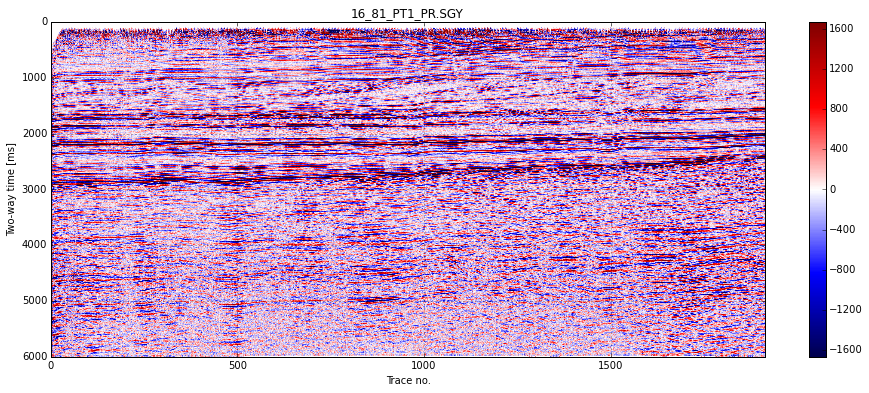

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plot_seismic(line1,twt1,file1)

Another example, this time with a gray colorbar:

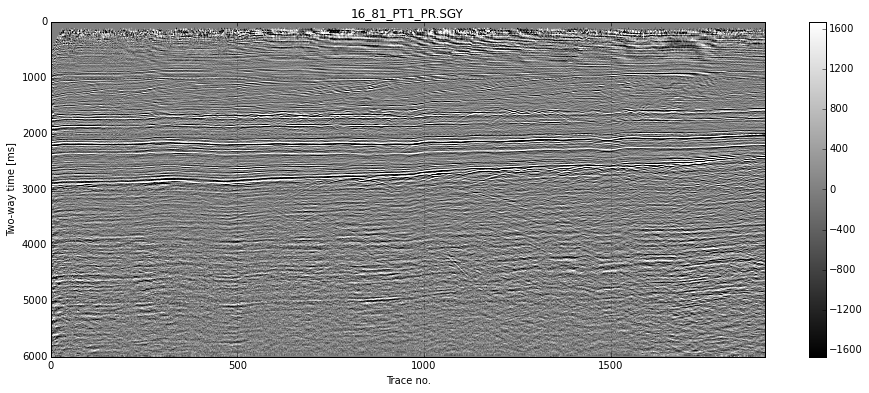

In [45]:
plot_seismic(line1,twt1,file1,colr=cm.gray)

This is a way to zoom in, for example in the window from 1 to 2 seconds:

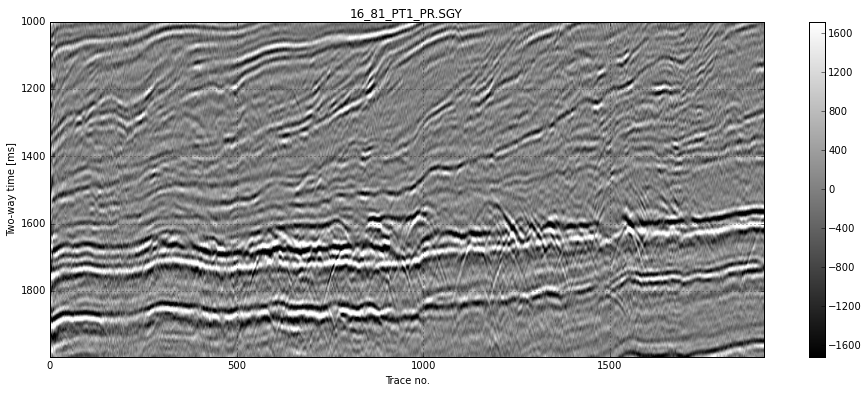

In [46]:
uu=1000; ll=2000

line1_zoom=line1[twt1.tolist().index(uu):twt1.tolist().index(ll),:]
twt1_zoom=twt1[twt1.tolist().index(uu):twt1.tolist().index(ll)]

plot_seismic(line1_zoom,twt1_zoom,file1,colr=cm.gray)

As you can see, in the `plot_seismic` function you can also choose your preferred colormaps (it defaults to the classic red-blue seismic map). Try also `cm.seismic`, `cm.coolwarm`, `cm.RdGy` (and don't forget to read these  essays on colormaps by [Matteo](http://nbviewer.ipython.org/github/mycarta/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb) and [Jake]( https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
)).

All the colormaps available in [matplotlib](http://matplotlib.org/) are listed here:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps 

# Comparison displays

Let's assume we want to build a comparison display to see two (or more) lines at once. I was thinking a classical near-far stack display but since I just have full stacks in this Alaska dataset I need to create other versions of the same line.

So let's play with the data and create one version with noise added and another one with a smoothing filter applied (code for adding noise and smoothing the data taken straight from [this notebook by Matt Hall](http://nbviewer.ipython.org/github/agile-geoscience/notebooks/blob/master/Filtering_horizons.ipynb):

In [47]:
noise = np.random.uniform(-500,500, line1_zoom.shape)
line1_noise = line1_zoom + noise

import scipy.signal
kernel = np.ones((5,5)) / 25
line1_filt = scipy.signal.convolve2d(line1_zoom, kernel)

Let's see them all:

<matplotlib.colorbar.Colorbar instance at 0x0B1934E0>

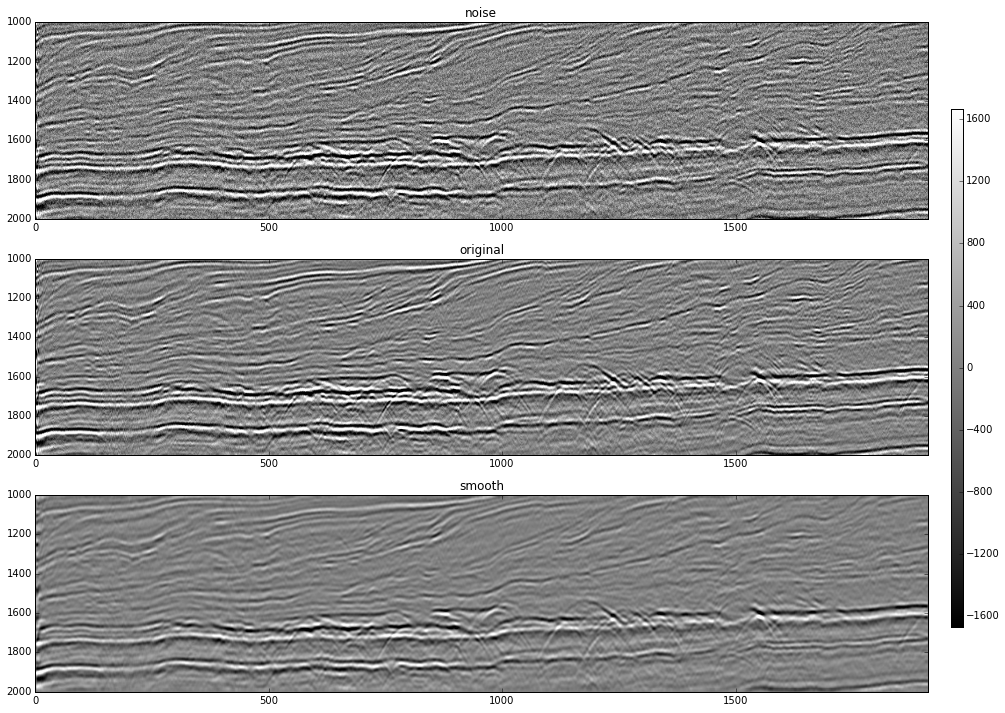

In [48]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(16,12),facecolor='w')
im0=ax[0].imshow(line1_noise,interpolation='bilinear',aspect='auto',cmap=cm.gray,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
im1=ax[1].imshow(line1_zoom, interpolation='bilinear',aspect='auto',cmap=cm.gray,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
im2=ax[2].imshow(line1_filt, interpolation='bilinear',aspect='auto',cmap=cm.gray,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
ax[0].set_title('noise'), ax[1].set_title('original'), ax[2].set_title('smooth')
cax = f.add_axes([0.92, 0.2, 0.01, 0.6])
f.colorbar(im0, cax=cax, orientation='vertical')

# Loading data with Segpy

First we import the data:

In [49]:
import segypy

filename='16_81_PT1_PR.SGY'

f=open(filename, 'rb')
data,header,trace_headers=segypy.read_segy(f)

Let's get some stats:

In [50]:
clip=abs(np.percentile(data, 0.999))

print 'number of traces: %d, samples: %d, sample rate: %d' % (header['ntraces'], header['ns'], header['dt'])
print 'trace length (ms): %.2f' % (header['dt']/1e3 * header['ns'])
print 'value to clip data display: %f' % clip
print 'size in Kb of imported seismic: %.0f' % (data.nbytes/1024)

number of traces: 1912, samples: 1501, sample rate: 4000
trace length (ms): 6004.00
value to clip data display: 1667.944575
size in Kb of imported seismic: 22421


And a plot:

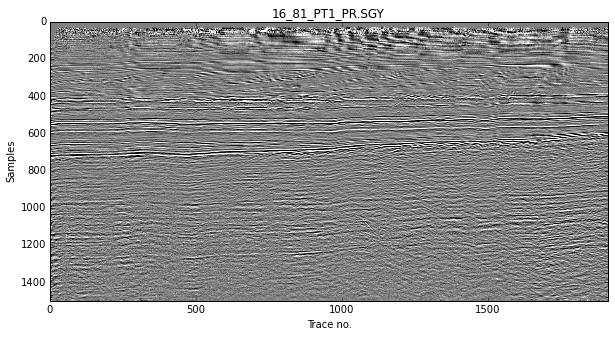

In [57]:
plt.figure(figsize=(10,5))
plt.imshow(data,interpolation='bilinear',aspect='auto',vmin=-clip,vmax=clip,cmap=cm.gray)
plt.title('%s' % filename)
plt.ylabel('Samples')
plt.xlabel('Trace no.')

Note that the vertical scale is in samples. We can define a two-way-time vector similarly to what I've done in the `copy_segy` function defined earlier:

In [59]:
lag=0
twt=np.arange(lag,lag+header['ns']*header['dt']/1000.,header['dt']/1000.)

Then plot the seismic line with proper labelling:

<matplotlib.colorbar.Colorbar instance at 0x0B907828>

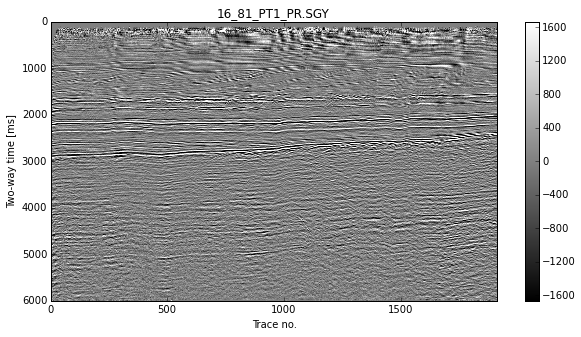

In [58]:
plt.figure(figsize=(10,5))
im=plt.imshow(data,interpolation='bilinear',aspect='auto',vmin=-clip,vmax=clip,cmap=cm.gray,extent=(0,header['ntraces'],twt[-1],twt[0]))
plt.title('%s' % filename)
plt.ylabel('Two-way time [ms]')
plt.xlabel('Trace no.')
plt.colorbar(im)

We can also use the `plot_seismic` function defined above:

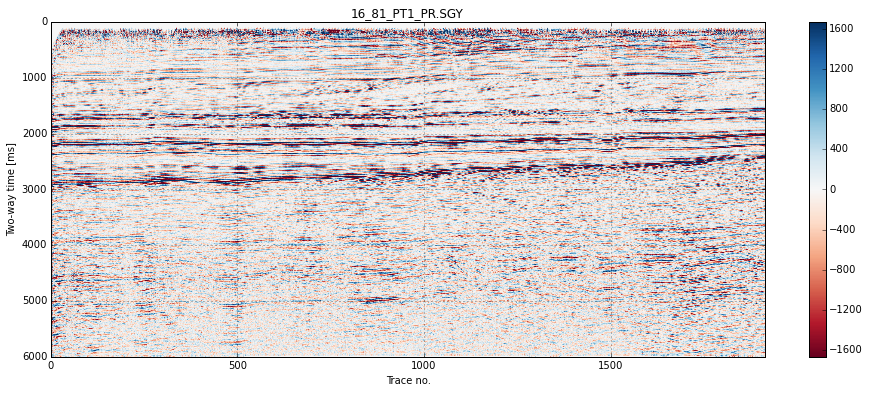

In [70]:
plot_seismic(data,twt,filename,colr=cm.RdBu)

I need to modify the function to correctly handle subset of the input data (in terms of displaying the correct two-way-times and trace numbers). For now I'll build such plots from scratch, for example:

<matplotlib.colorbar.Colorbar instance at 0x0C1EAA08>

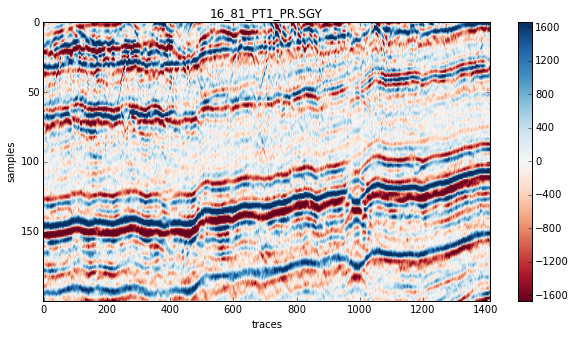

In [72]:
plt.figure(figsize=(10,5))
im=plt.imshow(data[400:600,500:2000],interpolation='bilinear',aspect='auto',vmin=-clip,vmax=clip,cmap=cm.RdBu)
plt.title('%s' % filename)
plt.ylabel('samples')
plt.xlabel('traces')
plt.colorbar(im)